In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from scipy.ndimage import rotate

%matplotlib inline

def load_data(data_dir):
    
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [2]:
# Load training and testing datasets.
train_data_dir = os.path.join("Training")
#test_data_dir = os.path.join('Testing')

images, labels = load_data(train_data_dir)
#print the number of labels and number of images
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 11
Total Images: 2200


In [3]:
#print the actual shape of first 5 images
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
    
#resize the images to be 32*32 size
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]

#print the new shape of first 5 images
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (39, 40, 3), min: 22, max: 255
shape: (72, 68, 3), min: 7, max: 255
shape: (96, 90, 3), min: 7, max: 255
shape: (59, 59, 3), min: 4, max: 255
shape: (54, 57, 3), min: 16, max: 255
shape: (32, 32, 3), min: 0.11655177696078423, max: 0.99921875
shape: (32, 32, 3), min: 0.05575980392156846, max: 1.0
shape: (32, 32, 3), min: 0.06262254901960784, max: 1.0
shape: (32, 32, 3), min: 0.05923808976715677, max: 1.0
shape: (32, 32, 3), min: 0.09271024816176508, max: 1.0


In [4]:
labels_a_old = np.array(labels)
#labels_a = labels_a.astype(np.float32)
images_a_old = np.array(images32)
images_a_old = images_a_old.astype(np.float32)

#shuffle the images and labels
images_a_old, labels_a_old = shuffle(images_a_old, labels_a_old, random_state=0)

print("labels: ", labels_a_old.shape, "\nimages: ", images_a_old.shape)

labels:  (2200,) 
images:  (2200, 32, 32, 3)


In [5]:
print ("mean before normalization:", np.mean(images_a_old)) 
print ("std before normalization:", np.std(images_a_old))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(images_a_old.shape)

for i in range(3):
    mean[i] = np.mean(images_a_old[:,:,:,i])
    std[i] = np.std(images_a_old[:,:,:,i])
    
for i in range(3):
    newX_train[:,:,:,i] = images_a_old[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
      
    
images_a_old = newX_train

print ("mean after normalization:", np.mean(images_a_old))
print ("std after normalization:", np.std(images_a_old))

mean before normalization: 0.335615
std before normalization: 0.276818
mean after normalization: -1.81776644777e-07
std after normalization: 0.999999832286


In [6]:
# Image data augmentation
#function for random degree rotation
def random_rotation(image_array:np.array):
    #pick a random degree of rotation between 30 degree on left and 30 degree on right
    random_degree = random.uniform(-30,30)
    return sk.transform.rotate(image_array,random_degree)


In [7]:
#last index of images_a
endindex=len(images_a_old)-1

In [8]:
#create a temp copy of array of images
temp_images_a=np.array(images_a_old)

In [9]:
images_x=np.array(images_a_old)

In [10]:
#loop over temp_images_a
for i in range (0 , endindex):
    #rotate elements of images_a
    images_x[i]=random_rotation(temp_images_a[i])

In [11]:
#flip images horizontally
flip_images_a=temp_images_a[:,:,::-1]

In [12]:
images_a=np.concatenate((images_x,flip_images_a,images_a_old),axis=0)
labels_a=np.concatenate((labels_a_old,labels_a_old,labels_a_old),axis=0)

#convert to float type
images_a = images_a.astype(np.float32)

#shuffle the images again after data rotation
images_a, labels_a = shuffle(images_a, labels_a, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


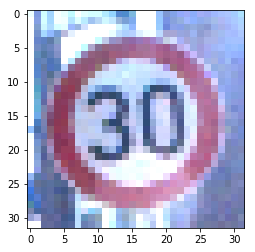

In [13]:
plt.imshow(images_a_old[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


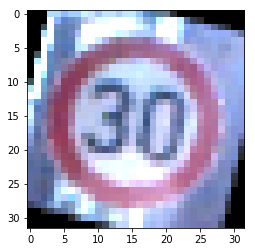

In [24]:
plt.imshow(images_x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


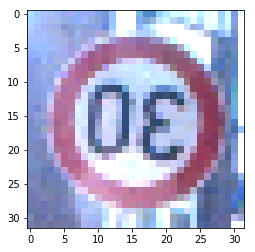

In [22]:
plt.imshow(flip_images_a[0])

In [14]:
dropout = 0.5 # Dropout, probability to keep units
dropout_train=1
dropout_test=1
beta = 0.01
#use os to get our current working directory so we can save variable there
file_path = os.getcwd()+'/model.ckpt'

In [15]:
graph = tf.Graph()
with graph.as_default():
    
    batch_size = 50 #batch_size
    map1 = 32 #input size
    reduce1x1 = 16 
    map2 = 64
    num_fc1 = 150
    num_fc2 = 11 #for number of classes
    
    keep_prob_ph = tf.placeholder(tf.float32) # dropout (keep probability)
    
    #train data and labels
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])
    
    #validation data
    #tf_valX = tf.placeholder(tf.float32,shape=(len(valX),28,28,1))
 
    #test data
    #tf_testX=tf.placeholder(tf.float32,shape=(test_batch_size,28,28,1))
 
    #def createWeight(size,Name):
    #    return tf.Variable(tf.truncated_normal(size, stddev=0.1),name=Name)
 
    #def createBias(size,Name):
    #    return tf.Variable(tf.constant(0.1,shape=size),name=Name)
 
    def conv2d_s1(x,W):
        return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
 
    def max_pool_3x3_s1(x):
        return tf.nn.max_pool(x,ksize=[1,3,3,1],
                             strides=[1,1,1,1],padding='SAME')
    #Inception Layer 1
    # follows input image layer
    W_conv1_1x1_1 = tf.cast(tf.Variable(tf.truncated_normal([1, 1, 3, map1], mean=0, stddev=0.1)),tf.float32)
    # follows input image layer
    b_conv1_1x1_1 = tf.cast(tf.Variable(tf.truncated_normal([map1], mean=0, stddev=0.1)),tf.float32)

    # follows input image layer but reduced dimension before 3*3
    W_conv1_1x1_2 = tf.cast(tf.Variable(tf.truncated_normal([1, 1, 3, reduce1x1], mean=0, stddev=0.1)),tf.float32)
    # follows input image layer but reduced dimension before 3*3
    b_conv1_1x1_2 = tf.cast(tf.Variable(tf.truncated_normal([reduce1x1], mean=0, stddev=0.1)),tf.float32)

    # follows input image layer but reduced dimension before 5*5
    W_conv1_1x1_3 = tf.cast(tf.Variable(tf.truncated_normal([1, 1, 3, reduce1x1], mean=0, stddev=0.1)),tf.float32)
    # follows input image layer but reduced dimension before 5*5
    b_conv1_1x1_3 = tf.cast(tf.Variable(tf.truncated_normal([reduce1x1], mean=0, stddev=0.1)),tf.float32)

    # follows 1x1_2
    W_conv1_3x3 = tf.cast(tf.Variable(tf.truncated_normal([3, 3, reduce1x1, map1], mean=0, stddev=0.1)),tf.float32)
    # follows 1x1_2
    b_conv1_3x3 = tf.cast(tf.Variable(tf.truncated_normal([map1], mean=0, stddev=0.1)),tf.float32)

    # follows 1x1_3
    W_conv1_5x5 = tf.cast(tf.Variable(tf.truncated_normal([5, 5, reduce1x1, map1], mean=0, stddev=0.1)),tf.float32)
    # follows 1x1_3
    b_conv1_5x5 = tf.cast(tf.Variable(tf.truncated_normal([map1], mean=0, stddev=0.1)),tf.float32)

    # follows max pooling
    W_conv1_1x1_4 = tf.cast(tf.Variable(tf.truncated_normal([1, 1, 3, map1], mean=0, stddev=0.1)),tf.float32)
    # follows max pooling
    b_conv1_1x1_4 = tf.cast(tf.Variable(tf.truncated_normal([map1], mean=0, stddev=0.1)),tf.float32)

    #Inception Layer 2
    # follows input image layer
    W_conv2_1x1_1 = tf.cast(tf.Variable(tf.truncated_normal([1,1,4*map1,map2], mean=0, stddev=0.1)),tf.float32)
    # follows input image layer
    b_conv2_1x1_1 = tf.cast(tf.Variable(tf.truncated_normal([map2], mean=0, stddev=0.1)),tf.float32)

    # follows input image layer but reduced dimension before 3*3
    W_conv2_1x1_2 = tf.cast(tf.Variable(tf.truncated_normal([1, 1, 4*map1, reduce1x1], mean=0, stddev=0.1)),tf.float32)
    # follows input image layer but reduced dimension before 3*3
    b_conv2_1x1_2 = tf.cast(tf.Variable(tf.truncated_normal([reduce1x1], mean=0, stddev=0.1)),tf.float32)

    # follows input image layer but reduced dimension before 5*5
    W_conv2_1x1_3 = tf.cast(tf.Variable(tf.truncated_normal([1, 1, 4*map1, reduce1x1], mean=0, stddev=0.1)),tf.float32)
    # follows input image layer but reduced dimension before 5*5
    b_conv2_1x1_3 = tf.cast(tf.Variable(tf.truncated_normal([reduce1x1], mean=0, stddev=0.1)),tf.float32)

    # follows 1x1_2
    W_conv2_3x3 = tf.cast(tf.Variable(tf.truncated_normal([3, 3, reduce1x1, map2], mean=0, stddev=0.1)),tf.float32)
    # follows 1x1_2
    b_conv2_3x3 = tf.cast(tf.Variable(tf.truncated_normal([map2], mean=0, stddev=0.1)),tf.float32)

    # follows 1x1_3
    W_conv2_5x5 = tf.cast(tf.Variable(tf.truncated_normal([5, 5, reduce1x1, map2], mean=0, stddev=0.1)),tf.float32)
    # follows 1x1_3
    b_conv2_5x5 = tf.cast(tf.Variable(tf.truncated_normal([map2], mean=0, stddev=0.1)),tf.float32)

    # follows max pooling
    W_conv2_1x1_4 = tf.cast(tf.Variable(tf.truncated_normal([1, 1,4*map1,map2], mean=0, stddev=0.1)),tf.float32)
    # follows max pooling
    b_conv2_1x1_4 = tf.cast(tf.Variable(tf.truncated_normal([map2], mean=0, stddev=0.1)),tf.float32)
    
    #Fully connected layers
    # since padding is same, the feature map with there will be 4 32*32*map2
    W_fc1 = tf.cast(tf.Variable(tf.truncated_normal([32 * 32 * (4 * map2), num_fc1], mean=0, stddev=0.1)),tf.float32)
    b_fc1 = tf.cast(tf.Variable(tf.truncated_normal([num_fc1], mean=0, stddev=0.1)),tf.float32)

    W_fc2 = tf.cast(tf.Variable(tf.truncated_normal([num_fc1, num_fc2], mean=0, stddev=0.1)),tf.float32)
    b_fc2 = tf.cast(tf.Variable(tf.truncated_normal([num_fc2], mean=0, stddev=0.1)),tf.float32)
 
    def conv_net(x,keep_prob):
        #Inception Module 1
        conv1_1x1_1 = conv2d_s1(x,W_conv1_1x1_1)+b_conv1_1x1_1
        conv1_1x1_2 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_2)+b_conv1_1x1_2)
        conv1_1x1_3 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_3)+b_conv1_1x1_3)
        conv1_3x3 = conv2d_s1(conv1_1x1_2,W_conv1_3x3)+b_conv1_3x3
        conv1_5x5 = conv2d_s1(conv1_1x1_3,W_conv1_5x5)+b_conv1_5x5
        maxpool1 = max_pool_3x3_s1(x)
        conv1_1x1_4 = conv2d_s1(maxpool1,W_conv1_1x1_4)+b_conv1_1x1_4
 
        # concatenate kernel outputs and apply relu
        inception1 = tf.nn.relu(tf.concat([conv1_1x1_1, conv1_3x3, conv1_5x5, conv1_1x1_4],3))
        
        #Inception Module 2
        conv2_1x1_1 = conv2d_s1(inception1,W_conv2_1x1_1)+b_conv2_1x1_1
        conv2_1x1_2 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_2)+b_conv2_1x1_2)
        conv2_1x1_3 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_3)+b_conv2_1x1_3)
        conv2_3x3 = conv2d_s1(conv2_1x1_2,W_conv2_3x3)+b_conv2_3x3
        conv2_5x5 = conv2d_s1(conv2_1x1_3,W_conv2_5x5)+b_conv2_5x5
        maxpool2 = max_pool_3x3_s1(inception1)
        conv2_1x1_4 = conv2d_s1(maxpool2,W_conv2_1x1_4)+b_conv2_1x1_4
 
        #concatenate all the feature maps and hit them with a relu
        inception2 = tf.nn.relu(tf.concat([conv2_1x1_1,conv2_3x3,conv2_5x5,conv2_1x1_4],3))
        
        #flatten features for fully connected layer
        inception2_flat = tf.contrib.layers.flatten(inception2)
 
        #Fully connected layers
        h_fc1 =tf.nn.dropout(tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1),keep_prob)
        
        logits=tf.matmul(h_fc1,W_fc2)+b_fc2
        
        return logits
    
    logits=conv_net(images_ph,keep_prob_ph)
    predicted_labels=tf.argmax(logits, 1)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels_ph))
    # Loss function with L2 Regularization with beta=0.01
    #regularizers =  tf.nn.l2_loss(W_conv1_1x1_1) + tf.nn.l2_loss(W_conv1_1x1_2)+tf.nn.l2_loss(W_conv1_1x1_3) + tf.nn.l2_loss(W_conv1_3x3)+tf.nn.l2_loss(W_conv1_5x5) + tf.nn.l2_loss(W_conv1_1x1_4)+tf.nn.l2_loss(W_conv2_1x1_1) + tf.nn.l2_loss(W_conv2_1x1_2)+tf.nn.l2_loss(W_conv2_1x1_3) + tf.nn.l2_loss(W_conv2_3x3)+tf.nn.l2_loss(W_conv2_5x5) + tf.nn.l2_loss(W_conv2_1x1_4)+tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2)
    #loss = tf.reduce_mean(loss + beta * regularizers)
    
    opt = tf.train.AdamOptimizer(1e-4).minimize(loss)
 
    #predictions_val = tf.nn.softmax(model(tf_valX,train=False))
    #predictions_test = tf.nn.softmax(model(tf_testX,train=False))
 
    #initialize variable
    init=tf.global_variables_initializer()
 
    #use to save variables so we can pick up later
    saver = tf.train.Saver(tf.trainable_variables())     

In [16]:
num_steps = 200
sess = tf.Session(graph=graph)  

In [17]:
#initialize variables
sess.run(init)
print("Model initialized.") 

Model initialized.


In [73]:
#training
for s in range(1056):
    offset = (s*batch_size) % (len(images_a)-batch_size)
    batch_x,batch_y = images_a[offset:(offset+batch_size)],labels_a[offset:(offset+batch_size)]
    feed_dict={images_ph : batch_x, labels_ph : batch_y,keep_prob_ph:dropout}
    predicted_value,_,loss_value = sess.run([predicted_labels,opt,loss],feed_dict=feed_dict)
    if s%66== 0:
        print("Loss: ",loss_value,predicted_value)
        #feed_dict = {tf_valX : valX}
        #preds=sess.run(predictions_val,feed_dict=feed_dict)
 
        #print "step: "+str(s)
        #print "validation accuracy: "+str(accuracy(val_lb,preds))
        #print " "

Loss:  10.1831 [ 3  6  4  6  8  1  8  7  8  7  8  8  8  4 10 10  9  8  4 10  7  8  7  8  7
  7  8  4  7  6  3  7  6  6  8  4  8  7  8  7  6 10  8  8  8  8  7  8  8  1]
Loss:  1.91899 [8 0 0 1 0 4 1 0 2 8 1 5 8 0 0 3 3 5 4 0 1 1 1 0 2 3 2 0 4 0 9 9 2 3 8 4 6
 6 8 8 9 2 9 4 2 9 4 3 8 8]
Loss:  2.00631 [8 9 9 9 8 9 7 9 7 4 1 9 0 1 6 6 7 0 0 9 6 2 6 1 2 0 8 8 7 2 2 1 8 8 6 0 4
 9 6 8 1 8 9 9 2 4 8 8 4 0]
Loss:  1.78545 [2 1 2 0 1 2 1 4 0 6 4 1 1 0 2 1 6 8 8 4 8 9 2 1 7 9 9 2 8 8 1 6 9 0 1 6 6
 2 2 1 3 2 3 0 1 2 9 0 8 9]
Loss:  1.7956 [0 0 8 2 9 8 2 1 9 5 4 2 1 2 9 4 5 5 8 7 7 7 9 5 5 0 0 9 0 9 2 4 9 5 0 9 9
 1 8 7 5 8 8 6 9 4 9 1 9 4]
Loss:  1.60189 [ 3  4  8  6  8  9  8  8  8  2  5  1  2  1  6  2  9  7 10  0  8  9  7  1  4
  8  5  8  0  0  4  3  8 10  8  2  9  8  1  4  6  0  3 10  8  4  4  9  4  0]
Loss:  1.58964 [ 2  8  2  4  7  2  4 10  0  8  6  6  8  7  0  0  6  0  0  0  1  7  6  7  2
  6  0  0  9  4  2  6  1  0  3  7  1  1  7  7  2  0  9  4  2  2  5  0  1  8]
Loss:  1.31678 [ 7  6  2 

In [ ]:
save_path = saver.save(sess,file_path)
print("Model saved.")

In [18]:
#Restore previously trained model
saver.restore(sess,file_path)
print("Model restored.")

INFO:tensorflow:Restoring parameters from /home/aquib/Downloads/CarND-Term1-Starter-Kit/GTSRB/model.ckpt
Model restored.


In [24]:
#training accuracy
count=0
class_count=np.zeros(11)
print("Calculate training accuracy")
for s in range(132):
    offset = (s*batch_size) % (len(images_a)-batch_size)
    batch_x,batch_y = images_a[offset:(offset+batch_size)],labels_a[offset:(offset+batch_size)]
    feed_dict={images_ph : batch_x, labels_ph : batch_y,keep_prob_ph:dropout_train}
    predicted_value,loss_value = sess.run([predicted_labels,loss],feed_dict=feed_dict)
    for i in range(50):
        if((batch_y[i])==(predicted_value[i])):
            count+=1
            if(predicted_value[i]==0):
                class_count[0]=class_count[0]+1
            elif(predicted_value[i]==1):
                class_count[1]=class_count[1]+1
            elif(predicted_value[i]==2):
                class_count[2]=class_count[2]+1
            elif(predicted_value[i]==3):
                class_count[3]=class_count[3]+1
            elif(predicted_value[i]==4):
                class_count[4]=class_count[4]+1
            elif(predicted_value[i]==5):
                class_count[5]=class_count[5]+1
            elif(predicted_value[i]==6):
                class_count[6]=class_count[6]+1
            elif(predicted_value[i]==7):
                class_count[7]=class_count[7]+1
            elif(predicted_value[i]==8):
                class_count[8]=class_count[8]+1
            elif(predicted_value[i]==9):
                class_count[9]=class_count[9]+1
            else:
                class_count[10]=class_count[10]+1
                
                    
    if s%12== 0:
        print("Training Loss: ",loss_value,"\n",batch_y,"\n",predicted_value)
        #feed_dict = {tf_valX : valX}
        #preds=sess.run(predictions_val,feed_dict=feed_dict)
 
        #print "step: "+str(s)
        #print "validation accuracy: "+str(accuracy(val_lb,preds))
        #print " "        
        
print("Accuracy is",count*100/6600,"\n")
print("Class wise accuracy\n")
for i in range(11):
    print("Class label",i,class_count[i]/600)

Calculate training accuracy
Training Loss:  0.398565 
 [ 7  7  1  9  6  9  7  0 10  9 10 10  9  2  8  8  0  3  2  8  5  0  0  1 10
  3  8  8  2  6  4  5  6  8  4  5 10  1  2  4  1  8  3  6  3  4 10  8  7  7] 
 [ 7  7  1  9  6  9  7  0 10  9 10 10  9  2  7  7  0  3  2 10  5  0  0  4 10
  3  8  8  2  6  4  5  6  7  4  5 10  1  2  4  1  8  3  6  3  4 10  8  7  7]
Training Loss:  0.433467 
 [ 4  8  8  1  7  8  4 10  5  2  9  7  4  6  2  9  6  5  7  2  4  5  3  3  8
 10  8  1  1  5  0  8  3 10  1  3  2  9  3  7  4  9 10  4 10  1  3  7  1  6] 
 [ 4  8  7  1  7  7  9  8  5  2  9  7  4  6  2  9  6  5  7  2  4  5  3  3  8
 10  7  1  1  5  0  8  3 10  1  3  2  9  3  7  4  9  7  2 10  1  3  7  1  6]
Training Loss:  0.268232 
 [ 5  1  3  0  5  9  4 10  1 10  7  8 10  2  2 10  0  1  6  3  7  5  1  2 10
  8  6  1  4  5  9 10  0  6  6  2  9  0  9  2  0 10  4  6  0  4  1  4  9  9] 
 [ 5  4  3  0  5  9  4 10  1 10  7  8 10  2  2 10  0  1  6  3  7  5  1  2 10
  8  6  1  4  5  9 10  0  6  6  7  9  0  9  

In [75]:
#Pick 50 random samples
#sample_indexes= random.sample(range(len(images32)),50)
#sample_images = [images32[i] for i in sample_indexes]
#sample_labels = [labels[i] for i in sample_indexes]

#Run the "predicted_labels" operation
#predicted = sess.run([predicted_labels], feed_dict={images_ph:sample_images})[0]

#print(sample_labels)
#print(predicted)

In [25]:
#Load testing images
test_data_dir = os.path.join('Test_Train')

images_test, labels_test = load_data(test_data_dir)
#print the number of labels and number of images
print("Unique test Labels: {0}\nTotal test Images: {1}".format(len(set(labels_test)), len(images_test)))

Unique test Labels: 11
Total test Images: 440


In [26]:
class_img=images_test

In [29]:
class_img[0]=images_test[0]
class_img[1]=images_test[45]
class_img[2]=images_test[80]
class_img[3]=images_test[120]
class_img[4]=images_test[160]
class_img[5]=images_test[238]
class_img[6]=images_test[240]
class_img[7]=images_test[280]
class_img[8]=images_test[330]
class_img[9]=images_test[360]
class_img[10]=images_test[400]


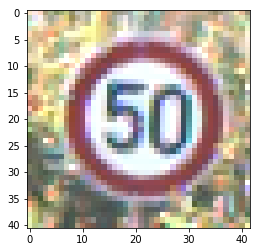

In [31]:
plt.imshow(class_img[8])

In [32]:
#print the actual shape of first 5 images
for image_test in images_test[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image_test.shape, image_test.min(), image_test.max()))
    
#resize the images to be 32*32 size
images32_test = [skimage.transform.resize(image_test, (32, 32), mode='constant')
                for image_test in images_test]

#print the new shape of first 5 images
for image_test in images32_test[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image_test.shape, image_test.min(), image_test.max()))

shape: (43, 42, 3), min: 9, max: 81
shape: (41, 36, 3), min: 7, max: 239
shape: (44, 41, 3), min: 10, max: 75
shape: (35, 36, 3), min: 6, max: 80
shape: (39, 40, 3), min: 22, max: 255
shape: (32, 32, 3), min: 0.04678883272058816, max: 0.3127010569852938
shape: (32, 32, 3), min: 0.0547411151960781, max: 0.9312997855392157
shape: (32, 32, 3), min: 0.05205652573529411, max: 0.29046032475490224
shape: (32, 32, 3), min: 0.03399586397058821, max: 0.2759727328431372
shape: (32, 32, 3), min: 0.11655177696078423, max: 0.99921875


In [33]:
labels_a_test = np.array(labels_test)
#labels_a = labels_a.astype(np.float32)
images_a_test = np.array(images32_test)
images_a_test = images_a_test.astype(np.float32)

#shuffle the images and labels
images_a_test, labels_a_test = shuffle(images_a_test, labels_a_test, random_state=0)
print("test labels: ", labels_a_test.shape, "\ntest images: ", images_a_test.shape)

test labels:  (440,) 
test images:  (440, 32, 32, 3)


In [34]:
print ("mean before normalization:", np.mean(images_a_test)) 
print ("std before normalization:", np.std(images_a_test))

mean=[0,0,0]
std=[0,0,0]
newX_test = np.ones(images_a_test.shape)

for i in range(3):
    mean[i] = np.mean(images_a_test[:,:,:,i])
    std[i] = np.std(images_a_test[:,:,:,i])
    
for i in range(3):
    newX_test[:,:,:,i] = images_a_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
      
    
images_a_test = newX_test

print ("mean after normalization:", np.mean(images_a_test))
print ("std after normalization:", np.std(images_a_test))

mean before normalization: 0.293974
std before normalization: 0.240114
mean after normalization: 1.984627032e-08
std after normalization: 0.999999940326


In [47]:
#Testing accuracy
count=0
dropout_test=0
class_test=np.zeros(11)
print("Calculate testing accuracy")
for s in range(44):
    offset = (s*10) % (len(images_a_test)-10)
    batch_x,batch_y = images_a_test[offset:(offset+10)],labels_a_test[offset:(offset+10)]
    feed_dict={images_ph : batch_x, labels_ph : batch_y,keep_prob_ph:1}
    predicted_value,loss_value = sess.run([predicted_labels,loss],feed_dict=feed_dict)
    for i in range(10):
        if((batch_y[i])==(predicted_value[i])):
            count+=1
            if(predicted_value[i]==0):
                class_test[0]=class_test[0]+1
            elif(predicted_value[i]==1):
                class_test[1]=class_test[1]+1
            elif(predicted_value[i]==2):
                class_test[2]=class_test[2]+1
            elif(predicted_value[i]==3):
                class_test[3]=class_test[3]+1
            elif(predicted_value[i]==4):
                class_test[4]=class_test[4]+1
            elif(predicted_value[i]==5):
                class_test[5]=class_test[5]+1
            elif(predicted_value[i]==6):
                class_test[6]=class_test[6]+1
            elif(predicted_value[i]==7):
                class_test[7]=class_test[7]+1
            elif(predicted_value[i]==8):
                class_test[8]=class_test[8]+1
            elif(predicted_value[i]==9):
                class_test[9]=class_test[9]+1
            else:
                class_test[10]=class_test[10]+1
                
    if s%4== 0:
        print("Testing Loss: ",loss_value,"\n",batch_y,"\n",predicted_value)      
    
print("Accuracy is",count*100/440)
print("Test Class wise accuracy\n")
for i in range(11):
    print("Class label",i,class_test[i]*100/40,"%")

Calculate testing accuracy
Testing Loss:  1.01775 
 [ 6  2  5  4  7 10  3  4  5  4] 
 [6 2 5 3 7 5 3 9 5 4]
Testing Loss:  1.38203 
 [3 1 3 8 3 0 8 6 9 8] 
 [3 1 3 8 3 2 9 9 9 8]
Testing Loss:  0.924393 
 [ 8  0  4  3  7  7  7 10  7  5] 
 [ 8  0  4  3  7  7  7 10  3  5]
Testing Loss:  0.679149 
 [8 4 4 4 7 1 9 4 1 1] 
 [1 4 4 4 7 1 9 4 0 1]
Testing Loss:  1.76479 
 [ 8  2  9  9 10  3  0  6 10  8] 
 [ 8  0  9  7 10  3  0  6  5  8]
Testing Loss:  1.80999 
 [0 9 6 1 9 5 8 1 7 2] 
 [ 0  9  6  5  9 10  8  5  7  0]
Testing Loss:  0.449873 
 [ 2  0  6 10  6  6  6  2  6  6] 
 [ 2  0  9 10  6  6  6  4  6  6]
Testing Loss:  3.0158 
 [ 4  3  6  5  4  2  5  2 10  5] 
 [ 7  8  6  7  4  0  0  2 10  3]
Testing Loss:  1.68914 
 [ 2  2  9  3  6  7  2  3  0 10] 
 [ 2  2  7  3  6  3  5  3  0 10]
Testing Loss:  2.38805 
 [6 8 3 9 1 8 8 5 8 2] 
 [6 8 7 9 1 8 3 5 8 0]
Testing Loss:  1.74214 
 [3 4 1 0 8 2 2 0 5 8] 
 [3 4 0 4 1 9 2 5 3 7]
Accuracy is 62.27272727272727
Test Class wise accuracy

Class label 0 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

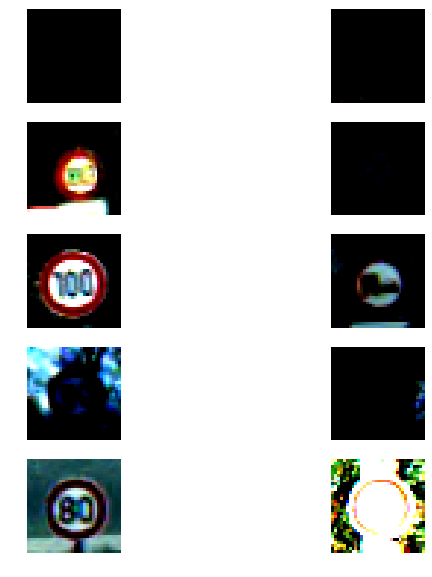

In [241]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range((10)):
    truth = labels_a_test[i]
    prediction = predicted_value[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')

    plt.imshow(images_a_test[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


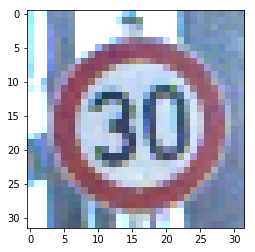

In [43]:
plt.imshow(images_a_test[15])